In [225]:
!python -V

Python 3.9.21


In [226]:
import pandas as pd

In [227]:
import pickle

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

In [229]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [230]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location=('/Users/ioanatiriac/Apple MacBook/Documents - Ioana’s MacBook Pro/MLOps '
 'Zoomcamp/mlops-zoomcamp/02-experiment-tracking/mlruns/1'), creation_time=1748638174637, experiment_id='1', last_update_time=1748638174637, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [231]:
df = pd.read_parquet('./data/green_tripdata_2025-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [232]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

6.704280150867817

/var/folders/0h/t32kl97959g3mkhsrgrx43h80000gn/T/ipykernel_40199/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/0h/t32kl97959g3mkhsrgrx43h80000gn/T/ipykernel_40199/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

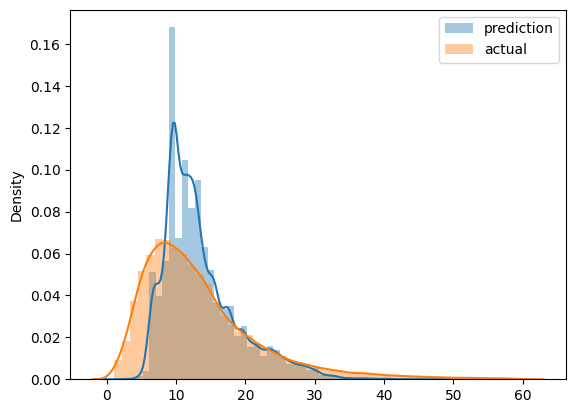

In [233]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [234]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [235]:
df_train = read_dataframe('./data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2025-02.parquet')

In [236]:
len(df_train), len(df_val)

(46307, 44218)

In [237]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [238]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [239]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [240]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_


6.098880755883313

In [241]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [242]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Ioana")

    mlflow.log_param("train-data-path", "green_tripdata_2025-01.parquet")
    mlflow.log_param("valid-data-path", "green_tripdata_2025-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_


In [243]:
import xgboost as xgb

In [244]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [245]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [246]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [247]:
# search space = the ranges in which we want hyperopt to explore hyperparam.
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    trials=Trials()
    max_evals=50,
)

SyntaxError: invalid syntax (2152304000.py, line 17)

In [251]:
import mlflow.xgboost


best_params = {
    'learning_rate': 0.07937775314716887,
    'max_depth': 22,
    'min_child_weight': 3.768769984027134,
    'objective': 'reg:squarederror',
    'reg_alpha': 0.06160995181404985,
    'reg_lambda': 0.0061026519460950545,
    'seed': 42
}

# mlflow.xgboost.autolog()
mlflow.log_params(best_params)

booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

y_pred = booster.predict(valid)
rmse = root_mean_squared_error(y_val, y_pred)
mlflow.log_metric("rmse", rmse)

with open("models/preprocessor.b","wb") as f_out:
    pickle.dump(dv, f_out)

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:8.66221
[1]	validation-rmse:8.26780
[2]	validation-rmse:7.91648
[3]	validation-rmse:7.60620
[4]	validation-rmse:7.33152
[5]	validation-rmse:7.09055
[6]	validation-rmse:6.87789
[7]	validation-rmse:6.69189
[8]	validation-rmse:6.52858
[9]	validation-rmse:6.38628
[10]	validation-rmse:6.26063
[11]	validation-rmse:6.15130
[12]	validation-rmse:6.05716
[13]	validation-rmse:5.97387
[14]	validation-rmse:5.90248
[15]	validation-rmse:5.83922
[16]	validation-rmse:5.78381
[17]	validation-rmse:5.73580
[18]	validation-rmse:5.69434
[19]	validation-rmse:5.65818
[20]	validation-rmse:5.62768
[21]	validation-rmse:5.59952
[22]	validation-rmse:5.57580
[23]	validation-rmse:5.55527
[24]	validation-rmse:5.53550
[25]	validation-rmse:5.51882
[26]	validation-rmse:5.50328
[27]	validation-rmse:5.49033
[28]	validation-rmse:5.47853
[29]	validation-rmse:5.46780
[30]	validation-rmse:5.45922
[31]	validation-rmse:5.45076
[32]	validation-rmse:5.44421
[33]	validation-rmse:5.43803
[34]	validation-rmse:5.4

2025/06/03 20:45:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
/opt/homebrew/Caskroom/miniconda/base/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/03 20:45:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatur

In [ ]:
logged_model = 'runs:/3b18d3c6857746a28663a0a3cc5c59c4/models_mlflow'

# Load model as a PyFuncModel
loaded_model = mlflow.pyfunc.load_model(logged_model)
